# AutoEncoder DEMO

Sin波を学習させたAutoEncoder異常検知モデルのDEMOノートブック

時系列データ向けにLSTMブロックを組み込んだAutoEncoderとした

参考：
https://qiita.com/kazetof/items/046339d3ccad24e0e5f4

## データ準備

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def make_data(random_factor, number_of_cycles, \
                timesteps, sampling_num_pair):
  
    def _load_data(data, n_prev = 100):  
        """
        data should be pd.DataFrame()
        """
        docX, docY = [], []
        for i in range(len(data)-n_prev):
            docX.append(data.iloc[i:i+n_prev].values)
        alsX = np.array(docX)

        return alsX

    def _train_test_split(df, test_size=0.1, n_prev = 100):  
        """
        This just splits data to training and testing parts
        """
        ntrn = round(len(df) * (1 - test_size))
        ntrn = int(ntrn)
        X_train = _load_data(df.iloc[0:ntrn], n_prev)
        X_test = _load_data(df.iloc[ntrn:], n_prev)

        return X_train, X_test

    np.random.seed(0)
    
    sampling_num1 = sampling_num
    # 学習用Sin波 
    df1 = pd.DataFrame(np.arange(sampling_num1 * number_of_cycles + 1), columns=["t"])
    df1["sin_t"] = df1.t.apply(lambda x: np.sin(x * (2 * np.pi / sampling_num1)+ np.random.uniform(-1.0, +1.0) * random_factor))
    # 確認用異常Sin波
    df2 = pd.DataFrame(np.arange(sampling_num1 * number_of_cycles + 1), columns=["t"])
    df2["sin_t"] = df2.t.apply(lambda x: np.sin(x * (2 * np.pi / sampling_num1)+ np.random.uniform(-1.0, +1.0) * random_factor*10))

    X_train, X_test = _train_test_split(df1[["sin_t"]], n_prev=timesteps) 
    X_anormal, X_anormal_test = _train_test_split(df2[["sin_t"]], n_prev=timesteps) 

    return X_train, X_test, X_anormal, X_anormal_test, df1,df2

# 乱数の係数
random_factor = 0.05
# 生成するサイクル数
number_of_cycles = 200
# 1サイクルの中で，何点サンプリングするか．
# sampling_num_pair=(20,80)
sampling_num = 80
# windowの長さ．一つの系列の長さになる．
timesteps = 100

X_train, X_test, X_anormal, X_anormal_test, df1,df2 = make_data(random_factor, number_of_cycles, timesteps, sampling_num_pair)
print("X_train.shape : ", X_train.shape)
print("X_test.shape : ", X_test.shape)

X_train.shape :  (14301, 100, 1)
X_test.shape :  (1500, 100, 1)


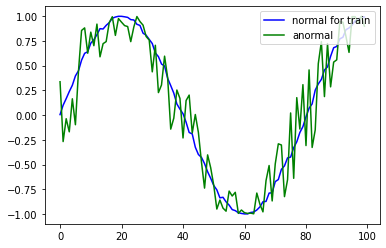

In [ ]:
# 生成したSin波をプロットする．
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(df1["sin_t"][0:100], label="normal for train", color="blue")
ax.plot(df2["sin_t"][0:100], label="anormal", color="green")
ax.legend(loc="upper right")

## モデル作成

In [ ]:
from keras.layers import Input, LSTM, RepeatVector, concatenate, Dense
from keras.models import Model

input_dim = 1
latent_dim = 10

# encode
inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(latent_dim, activation="tanh", recurrent_activation="sigmoid", return_sequences=False)(inputs)

#decode
hidden = RepeatVector(timesteps)(encoded)
reverse_input = Input(shape=(timesteps, input_dim))
hidden_revinput = concatenate([hidden, reverse_input])
decoded = LSTM(latent_dim, activation="tanh", recurrent_activation="sigmoid", return_sequences=True)(hidden_revinput)
decoded = Dense(latent_dim, activation="relu")(decoded)
decoded = Dense(input_dim, activation="tanh")(decoded)


## Train

正常なSin波を学習させる

In [ ]:
# train
LSTM_AE = Model([inputs, reverse_input], decoded)
LSTM_AE.compile(optimizer='rmsprop', loss='mse')
X_train_rev = X_train[:,::-1,:]
LSTM_AE.fit([X_train, X_train_rev], X_train, epochs=100, batch_size=500, shuffle=True, validation_data=([X_train, X_train_rev], X_train))


Epoch 1/100
29/29 [==============================] - 8s 169ms/step - loss: 0.0091 - val_loss: 0.0078
Epoch 2/100
29/29 [==============================] - 4s 141ms/step - loss: 0.0083 - val_loss: 0.0074
Epoch 3/100
29/29 [==============================] - 4s 142ms/step - loss: 0.0079 - val_loss: 0.0067
Epoch 4/100
29/29 [==============================] - 4s 140ms/step - loss: 0.0078 - val_loss: 0.0071
Epoch 5/100
29/29 [==============================] - 4s 146ms/step - loss: 0.0076 - val_loss: 0.0072
Epoch 6/100
29/29 [==============================] - 4s 140ms/step - loss: 0.0074 - val_loss: 0.0088
Epoch 7/100
29/29 [==============================] - 4s 140ms/step - loss: 0.0073 - val_loss: 0.0096
Epoch 8/100
29/29 [==============================] - 4s 139ms/step - loss: 0.0072 - val_loss: 0.0067
Epoch 9/100
29/29 [==============================] - 4s 143ms/step - loss: 0.0071 - val_loss: 0.0072
Epoch 10/100
29/29 [==============================] - 4s 142ms/step - loss: 0.0070 - val_lo

## Predict

学習したデータ（正常データ）は元通りに復元できる

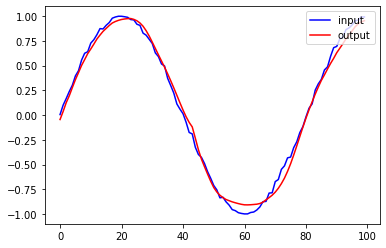

In [ ]:
X_hat_normal = LSTM_AE.predict([X_train, X_train_rev])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X_train[0][0:100,0], label="input", color="blue")
ax.plot(X_hat_normal[0][0:100,0], label="output", color="red")
ax.legend(loc="upper right")

学習していないデータ（異常データ）は、元通りに復元できない

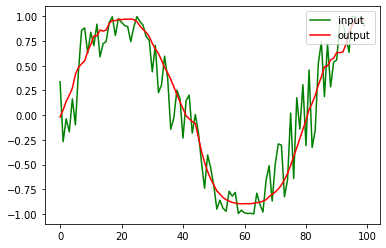

In [ ]:
X_anormal_rev = X_anormal[:,::-1,:]
X_hat_anormal = LSTM_AE.predict([X_anormal, X_anormal_rev])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X_anormal[0][0:100,0], label="input", color="green")
ax.plot(X_hat_anormal[0][0:100,0], label="output", color="red")
ax.legend(loc="upper right")